Classifying images of monkeys using CNN.
contributors: Natalie Pedigo, Kylie Quinney

In [ ]:
from keras import models
from keras import layers

In [ ]:
import tensorflow as tf
from glob import glob

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d slothkong/10-monkey-species

Dataset URL: https://www.kaggle.com/datasets/slothkong/10-monkey-species
License(s): CC0-1.0
10-monkey-species.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/10-monkey-species.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths to training and validation directories
train_dir = '/content/training/training'
test_dir = '/content/validation/validation'

def prep_fn(img):
    img = img.astype(np.float32) / 255.0
    img = (img - 0.5) * 2
    return img

# ImageDataGenerator to load and rescale the data to [-1,1]
train_datagen = ImageDataGenerator(preprocessing_function=prep_fn)
test_datagen = ImageDataGenerator(preprocessing_function=prep_fn)

# Load images from the training directory, use flow_from_directory to label
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(300, 500),  # Resizing images to 150x150 (you can adjust this)
    batch_size=32,  # Batch size
    class_mode='categorical'  # For multi-class classification
)

# Load images from the validation (test) directory
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(300, 500),
    batch_size=32,
    class_mode='categorical'
)


Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [ ]:
import numpy as np

# Function to convert generator data to arrays
def generator_to_arrays(generator, num_batches):
    images = []
    labels = []

    for _ in range(num_batches):
        # Get a batch of images and labels
        batch_images, batch_labels = next(generator)
        images.append(batch_images)
        labels.append(batch_labels)

    # Concatenate all batches into a single array
    images_array = np.concatenate(images, axis=0)
    labels_array = np.concatenate(labels, axis=0)

    return images_array, labels_array

# Convert training and testing data to arrays
train, train_labels = generator_to_arrays(train_generator, num_batches=10)  # Adjust the number of batches as needed
test, test_labels = generator_to_arrays(test_generator, num_batches=5)  # Adjust the number of batches as needed

# Check the shapes of the arrays
print("Train Images Shape:", train.shape)
print("Train Labels Shape:", train_labels.shape)
print("Test Images Shape:", test.shape)
print("Test Labels Shape:", test_labels.shape)


Train Images Shape: (320, 300, 500, 3)
Train Labels Shape: (320, 10)
Test Images Shape: (160, 300, 500, 3)
Test Labels Shape: (160, 10)


In [ ]:
import matplotlib.pyplot as plt
# Example: Access the first image and its label
first_image = train[0]
first_label = train_labels[0]

# Print the shape of the image and its label
print("Image Shape:", first_image.shape)
print("Label Shape:", first_label.shape)


Image Shape: (300, 500, 3)
Label Shape: (10,)


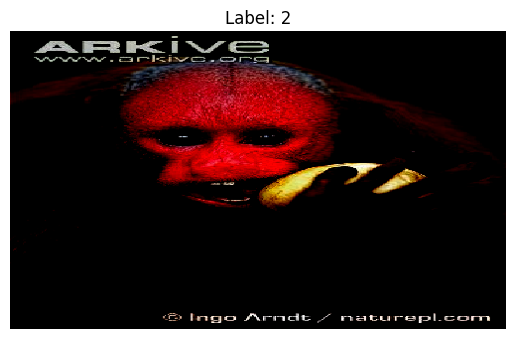

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display an image and its label
def display_image_and_label(image, label):
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.title(f'Label: {np.argmax(label)}')  # Get the class index from the one-hot encoding
    plt.show()

# Display the first training image and its label
display_image_and_label(train[0], train_labels[0])


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

BATCH_SIZE = 32

# Convert train and test NumPy arrays to TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train, train_labels))
validation_dataset = tf.data.Dataset.from_tensor_slices((test, test_labels))

# Apply batching to the datasets
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

# Apply prefetch to the datasets
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 4
Number of test batches: 1


In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (300,500) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 10, 16, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 300, 500, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 150, 250, 32)         864       ['input_7[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 150, 250, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 150, 250, 32)         0         ['bn_Conv1[

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(10, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 10)


In [ ]:
inputs = tf.keras.Input(shape=(300, 500, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x) #optional CAN BE CHANGED (aka removed)
x = tf.keras.layers.Dense(1280, activation='relu')(x) #CAN BE CHNAGED (i think)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 300, 500, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 10, 16, 1280)      2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_6 (Dense)             (None, 1280)              1639680   
                                                                 
 dense_5 (Dense)             (None, 10)                1281

In [ ]:
#compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')])

In [ ]:
#train the model
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

4/4 [==============================] - 4s 630ms/step - loss: 2.3565 - accuracy: 0.0703


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
10/10 [==============================] - 12s 889ms/step - loss: 2.1856 - accuracy: 0.2562 - val_loss: 1.9918 - val_accuracy: 0.5234
Epoch 2/10
10/10 [==============================] - 8s 819ms/step - loss: 1.7543 - accuracy: 0.7250 - val_loss: 1.6736 - val_accuracy: 0.7266
Epoch 3/10
10/10 [==============================] - 8s 861ms/step - loss: 1.3987 - accuracy: 0.8687 - val_loss: 1.3823 - val_accuracy: 0.8750
Epoch 4/10
10/10 [==============================] - 8s 849ms/step - loss: 1.1026 - accuracy: 0.9312 - val_loss: 1.1292 - val_accuracy: 0.9141
Epoch 5/10
10/10 [==============================] - 8s 882ms/step - loss: 0.8603 - accuracy: 0.9750 - val_loss: 0.9244 - val_accuracy: 0.9375
Epoch 6/10
10/10 [==============================] - 9s 897ms/step - loss: 0.6549 - accuracy: 0.9844 - val_loss: 0.7635 - val_accuracy: 0.9453
Epoch 7/10
10/10 [==============================] - 9s 867ms/step - loss: 0.5186 - accuracy: 0.9875 - val_loss: 0.6363 - val_accuracy: 0.9453
Epoch

1/1 [==============================] - 2s 2s/step


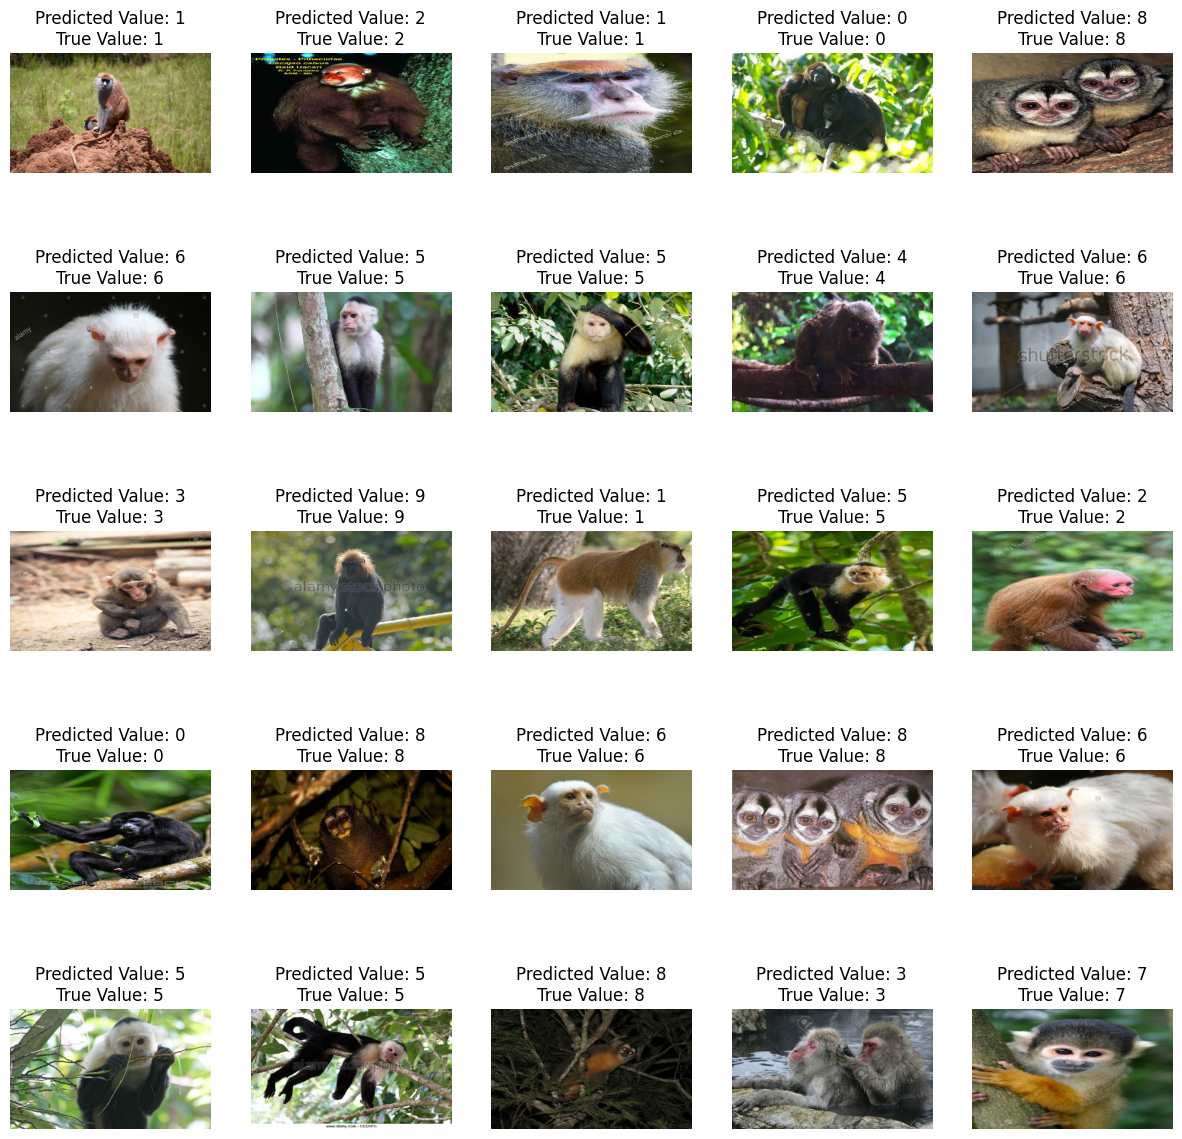

In [ ]:
#show 25 example images with predicted label and true label
image_batch, label_batch = next(iter(test_dataset))
predictions = model.predict(image_batch)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(label_batch, axis=1)
plt.figure(figsize=(15, 15))
#rescale the images
image_batch = (image_batch - np.min(image_batch)) / (np.max(image_batch) - np.min(image_batch))
for i in range(25):  # Display 25 images
    plt.subplot(5, 5, i + 1)
    plt.imshow(image_batch[i])
    plt.title(f"Predicted Value: {predicted_labels[i]}\nTrue Value: {true_labels[i]}")
    plt.axis('off')  # Hide axes
plt.show()

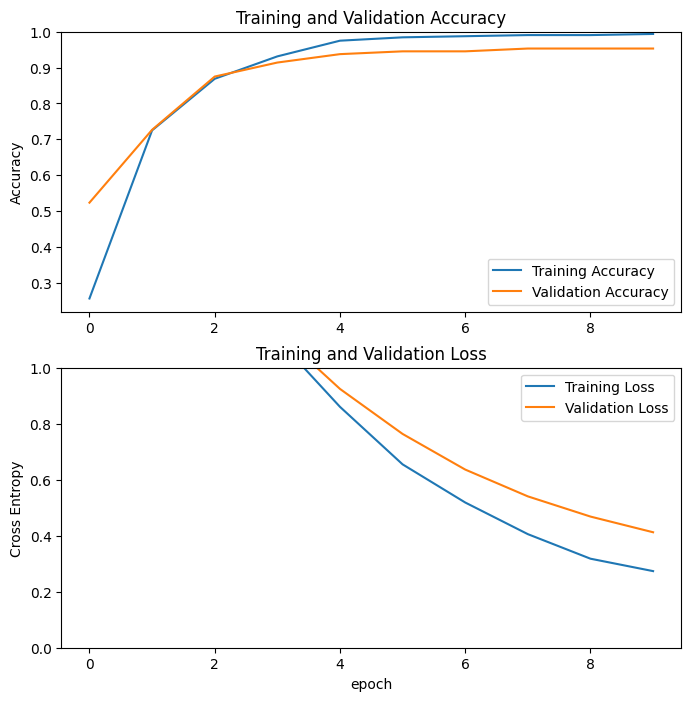

In [ ]:
#model evaluation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()